# For Three-pendulum, the Hamiltonian is

Three-pendulum system has three masses, $m_1, m_2, m_3$, three strings $L_1, L_2, L_3$ and three angles $\phi_1, \phi_2, \phi_3$

Through calculation for each mass's poential energy and kinetic energy, the $\mathcal{H}$ is simply $T + V$.  


Hamilton's equations are

$\begin{align}
  \dot\phi_1 &=  \frac{p_\phi(1)}{m_1L_1} \\
  \dot\phi_2 &=  \frac{p_\phi(2)}{m_2L_2} \\
  \dot\phi_3 &=  \frac{p_\phi(3)}{m_3L_3} \\
  \dot p_\phi(1) &= -\frac{\partial\mathcal{H}}{\partial \phi_1} = -(m_1+m_2+m_3)gL_1sin(\phi_1)+(m_2+m_3)L_1L_2\dot\phi_1\dot\phi_2-m_3L_1L_2L_3\dot\phi_1\dot\phi_2\dot\phi_3sin(\phi_3-\phi_1+\phi_2)
  \\
   \dot p_\phi(2) &= -\frac{\partial\mathcal{H}}{\partial \phi_2} = -(m_2+m_3)gL_2sin(\phi_2)-(m_2+m_3)L_1L_2\dot\phi_1\dot\phi_2+m_3L_1L_2L_3\dot\phi_1\dot\phi_2\dot\phi_3sin(\phi_3-\phi_1+\phi_2)
  \\
   \dot p_\phi(3) &= -\frac{\partial\mathcal{H}}{\partial \phi_3} = -m_3gL_3sin(\phi_3)+m_3L_1L_2L_3\dot\phi_1\dot\phi_2\dot\phi_3sin(\phi_3-\phi_1+\phi_2)
  \;.
\end{align}$

In [1]:
%matplotlib inline

In [2]:
import numpy as np
from scipy.integrate import solve_ivp

import matplotlib.pyplot as plt

# Import explicitly the widgets we might use
import ipywidgets as widgets
from ipywidgets import HBox, VBox, Layout, Tab, Label, Checkbox
from ipywidgets import FloatSlider, IntSlider, Play, Dropdown, HTMLMath 
from IPython.display import display

# Animation
from matplotlib import animation, rc
from IPython.display import HTML

In [3]:
# The dpi (dots-per-inch) setting will affect the resolution and how large
#  the plots appear on screen and printed.  So you may want/need to adjust 
#  the figsize when creating the figure.
plt.rcParams['figure.dpi'] = 100.    # this is the default for notebook

# Change the common font size (smaller when higher dpi)
font_size = 10
plt.rcParams.update({'font.size': font_size})

## Pendulum class and utility functions

In [22]:
class HamiltonianPendulum():
    """
    Pendulum class implements the parameters and Hamilton's equations for 
     a simple pendulum (no driving or damping).
     
    Parameters
    ----------
        Length : float
        The length of the strings
        mass : float
        mass of pendulum

    Methods
    -------
    dy_dt(t, y)
        Returns the right side of the differential equation in vector y, 
        given time t and the corresponding value of y.
    """
    def __init__(self, L1=1., L2=1., L3=1., m1=1., m2=1., m3=1., g=1.):
        self.L1 = L1
        self.L2 = L2
        self.L3 = L3
        self.m1 = m1
        self.m2 = m2
        self.m3 = m3
        self.g = g
    def dy_dt(self, t, y):
        """
        This function returns the right-hand sides of Hamilton's eqs
        [dq1/dt dq2/dt dq3/dt dp1/dt dp2/dt dp3/dt] --> [dphi1/dt dphi2/dt dphi3/dt dp_phi1/dt dp_phi2/dt dp_phi3/dt]
        
        Parameters
        ----------
        t : float
            time 
        y : float
            y[0] = phi1(t) y[1] = phi2(t) y[2]= phi3(t) y[3]= p_phi1(t) y[4]=p_phi2(t) y[5]=p_phi3(t)
            
        Returns
        -------
        
        """
        return [y[3]/(self.m1*self.L1), y[4]/(self.m2*self.L2), y[5]/(self.m3*self.L3),\
                -( self.m1 + self.m2 + self.m3 ) * self.L1 * self.g * np.sin(y[0]) + (self.m2 + self.m3) * self.L1 * self.L2 * y[3]/self.m1 * y[4]/self.m2 * np.sin(y[0]-y[1]) - self.m3 * self.L1 * self.L2 * self.L3 * y[3]/self.m1 * y[4]/self.m2 * y[5]/self.m3 * np.sin(y[2] - y[0] + y[1]),\
                -( self.m2 + self.m3 ) * self.L2 * self.g * np.sin(y[1]) - (self.m2 + self.m3) * self.L1 * self.L2 * y[3]/self.m1 * y[4]/self.m2 * np.sin(y[0]-y[1]) + self.m3 * self.L1 * self.L2 * self.L3 * y[3]/self.m1 * y[4]/self.m2 * y[5]/self.m3 * np.sin(y[2] - y[0] + y[1]),\
                - self.m3 * self.L3 * self.g * np.sin(y[2]) + self.m3 * self.L1 * self.L2 * self.L3 * y[3]/self.m1 * y[4]/self.m2 * y[5]/self.m3 * np.sin(y[2] - y[0] + y[1])]

    
    def solve_ode(self, t_pts, q1_0, q2_0, q3_0, p1_0, p2_0, p3_0,
                  abserr=1.0e-10, relerr=1.0e-10):
        """
        Solve the ODE given initial conditions.
        Specify smaller abserr and relerr to get more precision.
        """
        y = [q1_0, q2_0, q3_0, p1_0, p2_0, p3_0] 
        solution = solve_ivp(self.dy_dt, (t_pts[0], t_pts[-1]), 
                             y, t_eval=t_pts, 
                             atol=abserr, rtol=relerr)
        q1, q2, q3, p1, p2, p3 = solution.y

        return q1, q2, q3, p1, p2, p3

In [5]:
def plot_y_vs_x(x, y, axis_labels=None, label=None, title=None, 
                color=None, linestyle=None, semilogy=False, loglog=False,
                ax=None):
    """
    Generic plotting function: return a figure axis with a plot of y vs. x,
    with line color and style, title, axis labels, and line label
    """
    if ax is None:        # if the axis object doesn't exist, make one
        ax = plt.gca()

    if (semilogy):
        line, = ax.semilogy(x, y, label=label, 
                            color=color, linestyle=linestyle)
    elif (loglog):
        line, = ax.loglog(x, y, label=label, 
                          color=color, linestyle=linestyle)
    else:
        line, = ax.plot(x, y, label=label, 
                    color=color, linestyle=linestyle)

    if label is not None:    # if a label if passed, show the legend
        ax.legend()
    if title is not None:    # set a title if one if passed
        ax.set_title(title)
    if axis_labels is not None:  # set x-axis and y-axis labels if passed  
        ax.set_xlabel(axis_labels[0])
        ax.set_ylabel(axis_labels[1])

    return ax, line

In [6]:
def start_stop_indices(t_pts, plot_start, plot_stop):
    start_index = (np.fabs(t_pts-plot_start)).argmin()  # index in t_pts array 
    stop_index = (np.fabs(t_pts-plot_stop)).argmin()  # index in t_pts array 
    return start_index, stop_index

## Make simple pendulum plots 

In [7]:
# Common plotting time (generate the full time then use slices)
t_start = 0.
t_end = 50.
delta_t = 0.001

t_pts = np.arange(t_start, t_end+delta_t, delta_t)  

L1 = 1.
L2 = 1.
L3 = 1.
g = 1.
m1 = 1.
m2 = 1.
m3 = 1.
# Instantiate a pendulum 
p1 = HamiltonianPendulum(L1=L1, L2=L2, L3=L3, m1=m1, m2=m2, m3=m3, g=g)


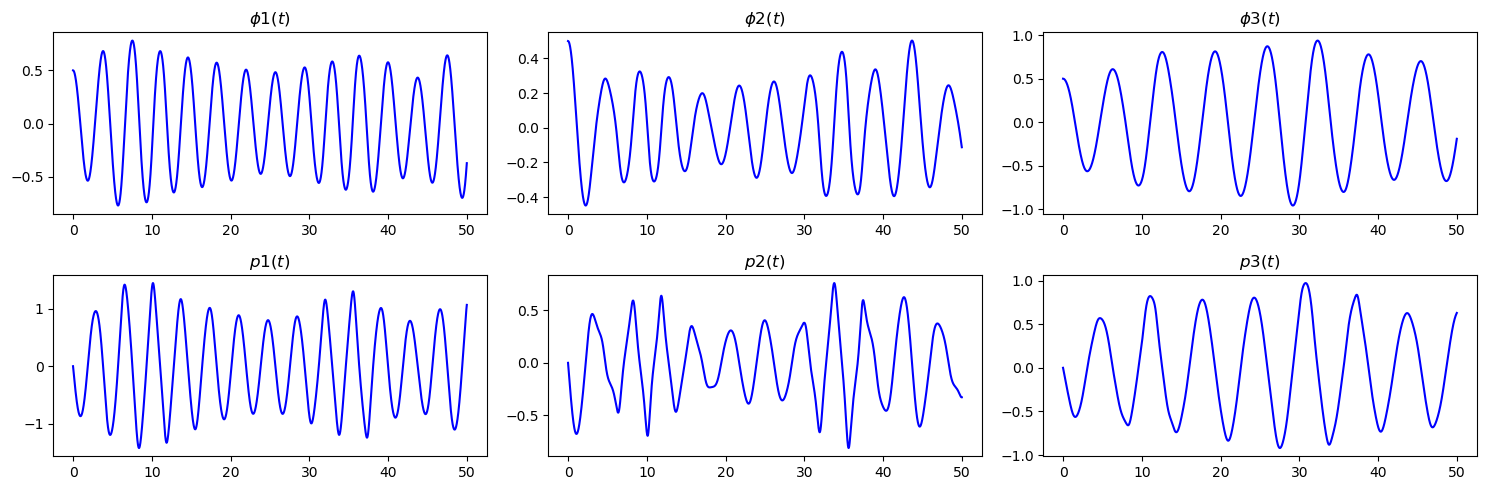

In [21]:
# same initial conditions
phi1_0 = 0.5
phi2_0 = 0.5
phi3_0 = 0.5
p_phi1_0 = 0.
p_phi2_0 = 0.
p_phi3_0 = 0.

phi1, phi2, phi3, p_phi1, p_phi2, p_phi3  = p1.solve_ode(t_pts, phi1_0, phi2_0, phi3_0, p_phi1_0, p_phi2_0, p_phi3_0)


# start the plot!
fig = plt.figure(figsize=(15,5))
    
# first plot: phi1 plot 
ax_a = fig.add_subplot(2,3,1)                  

start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(t_pts[start : stop], phi1[start : stop], 
            color='blue',
            label=None, 
            title=r'$\phi1(t)$', 
            ax=ax_a)    

# Second plot: phi2 plot 
ax_b = fig.add_subplot(2,3,2)                  

start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(t_pts[start : stop], phi2[start : stop], 
            color='blue',
            label=None, 
            title=r'$\phi2(t)$', 
            ax=ax_b)    

# third plot: phi3 plot 
ax_c = fig.add_subplot(2,3,3)                  

start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(t_pts[start : stop], phi3[start : stop], 
            color='blue',
            label=None, 
            title=r'$\phi3(t)$', 
            ax=ax_c)    

# Fourth plot: p_phi1 plot
ax_d = fig.add_subplot(2,3,4)                  

start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(t_pts[start : stop], p_phi1[start : stop], 
            color='blue',
            label=None, 
            title=r'$p1(t)$', 
            ax=ax_d)    

# Fifth plot: p_phi2 plot
ax_e = fig.add_subplot(2,3,5)                  

start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(t_pts[start : stop], p_phi2[start : stop], 
            color='blue',
            label=None, 
            title=r'$p2(t)$', 
            ax=ax_e)    

# Sixth plot: p_phi3 plot
ax_f = fig.add_subplot(2,3,6)                  

start, stop = start_stop_indices(t_pts, t_start, t_end)    
plot_y_vs_x(t_pts[start : stop], p_phi3[start : stop], 
            color='blue',
            label=None, 
            title=r'$p3(t)$', 
            ax=ax_f)    

fig.tight_layout()
fig.savefig('simple_pendulum_Hamilton.png', bbox_inches='tight')  

Now trying the power spectrum, plotting only positive frequencies and cutting off the lower peaks:

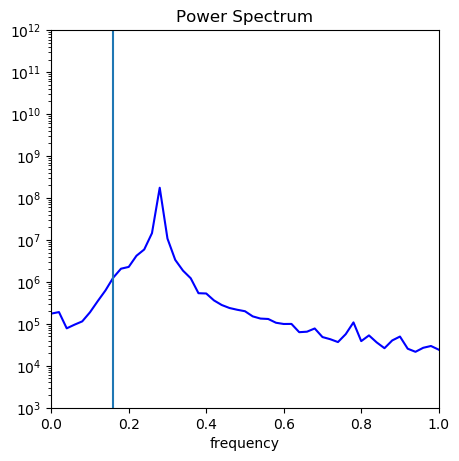

In [9]:
start, stop = start_stop_indices(t_pts, t_start, t_end)    
signal = phi1[start:stop]
power_spectrum = np.abs(np.fft.fft(signal))**2
freqs = np.fft.fftfreq(signal.size, delta_t)
idx = np.argsort(freqs)

fig_ps = plt.figure(figsize=(5,5))
ax_ps = fig_ps.add_subplot(1,1,1)
ax_ps.semilogy(freqs[idx], power_spectrum[idx], color='blue')
ax_ps.set_xlim(0, 1.)
ax_ps.set_ylim(1.e3, 1.e12)
ax_ps.set_xlabel('frequency')
ax_ps.set_title('Power Spectrum')
ax_ps.axvline(1./(2.*np.pi))

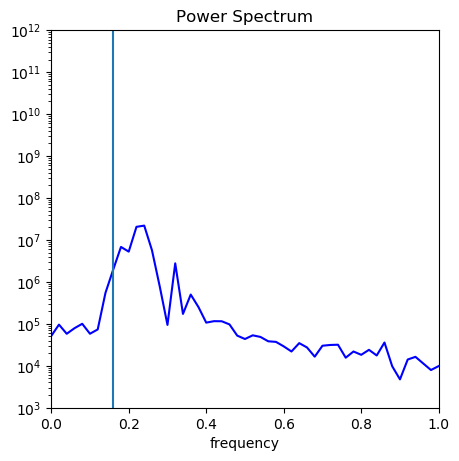

In [10]:
start, stop = start_stop_indices(t_pts, t_start, t_end)    
signal = phi2[start:stop]
power_spectrum = np.abs(np.fft.fft(signal))**2
freqs = np.fft.fftfreq(signal.size, delta_t)
idx = np.argsort(freqs)

fig_ps = plt.figure(figsize=(5,5))
ax_ps = fig_ps.add_subplot(1,1,1)
ax_ps.semilogy(freqs[idx], power_spectrum[idx], color='blue')
ax_ps.set_xlim(0, 1.)
ax_ps.set_ylim(1.e3, 1.e12)
ax_ps.set_xlabel('frequency')
ax_ps.set_title('Power Spectrum')
ax_ps.axvline(1./(2.*np.pi))

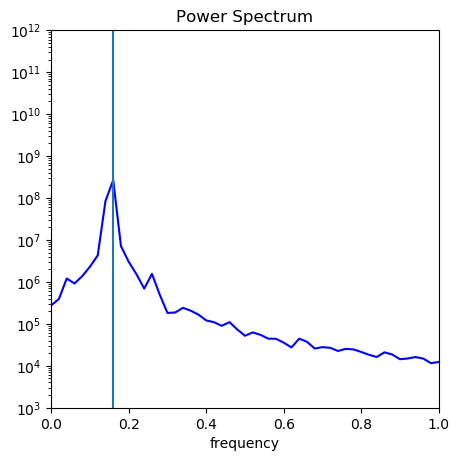

In [14]:
start, stop = start_stop_indices(t_pts, t_start, t_end)    
signal = phi3[start:stop]
power_spectrum = np.abs(np.fft.fft(signal))**2
freqs = np.fft.fftfreq(signal.size, delta_t)
idx = np.argsort(freqs)

fig_ps = plt.figure(figsize=(5,5))
ax_ps = fig_ps.add_subplot(1,1,1)
ax_ps.semilogy(freqs[idx], power_spectrum[idx], color='blue')
ax_ps.set_xlim(0, 1.)
ax_ps.set_ylim(1.e3, 1.e12)
ax_ps.set_xlabel('frequency')
ax_ps.set_title('Power Spectrum')
ax_ps.axvline(1./(2.*np.pi))

In [17]:
#Get the widget
def update_plot(phi1_0, phi2_0,phi3_0, p_phi1_0, p_phi2_0,p_phi3_0):
    phi1, phi2, phi3, p_phi1, p_phi2, p_phi3  = p1.solve_ode(t_pts, phi1_0, phi2_0, phi3_0, p_phi1_0, p_phi2_0, p_phi3_0)
    # start the plot!
    fig = plt.figure(figsize=(15,5))
    # first plot: phi1 plot 
    ax_a = fig.add_subplot(1,6,1)                  

    start, stop = start_stop_indices(t_pts, t_start, t_end)    
    plot_y_vs_x(t_pts[start : stop], phi1[start : stop], 
                color='blue',
                label=None, 
                title=r'$\phi1(t)$', 
                ax=ax_a)    

    # Second plot: phi2 plot 
    ax_b = fig.add_subplot(1,6,2)                  

    start, stop = start_stop_indices(t_pts, t_start, t_end)    
    plot_y_vs_x(t_pts[start : stop], phi2[start : stop], 
                color='blue',
                label=None, 
                title=r'$\phi2(t)$', 
                ax=ax_b)    

    # third plot: phi3 plot 
    ax_c = fig.add_subplot(1,6,3)                  

    start, stop = start_stop_indices(t_pts, t_start, t_end)    
    plot_y_vs_x(t_pts[start : stop], phi3[start : stop], 
                color='blue',
                label=None, 
                title=r'$\phi3(t)$', 
                ax=ax_c)    
    
    # Fourth plot: p_phi1 plot
    ax_d = fig.add_subplot(1,6,4)                  

    start, stop = start_stop_indices(t_pts, t_start, t_end)    
    plot_y_vs_x(t_pts[start : stop], p_phi1[start : stop], 
                color='blue',
                label=None, 
                title=r'$p1(t)$', 
                ax=ax_d)    

    # Fifth plot: p_phi2 plot
    ax_e = fig.add_subplot(1,6,5)                  

    start, stop = start_stop_indices(t_pts, t_start, t_end)    
    plot_y_vs_x(t_pts[start : stop], p_phi2[start : stop], 
                color='blue',
                label=None, 
                title=r'$p2(t)$', 
                ax=ax_e)    

    # Sixth plot: p_phi3 plot
    ax_f = fig.add_subplot(1,6,6)                  

    start, stop = start_stop_indices(t_pts, t_start, t_end)    
    plot_y_vs_x(t_pts[start : stop], p_phi3[start : stop], 
                color='blue',
                label=None, 
                title=r'$p3(t)$', 
                ax=ax_f)    
  
    
phi1_0_w = FloatSlider(value=1.0, min=0.1, max=10., step=0.1,
                      description=r'$\phi1_0_w$ :')
phi2_0_w = FloatSlider(value=1.0, min=0.1, max=10., step=0.1,
                      description=r'$\phi2_0_w$ :')
phi3_0_w = FloatSlider(value=1.0, min=0.1, max=10., step=0.1,
                      description=r'$\phi2_0_w$ :')
p_phi1_0_w = FloatSlider(value=1.0, min=0., max=10., step=0.1,
                      description=r'$\p_phi1_0_w$ :')
p_phi2_0_w = FloatSlider(value=1.0, min=0., max=10., step=0.1,
                      description=r'$\p_phi2_0_w$ :')
p_phi3_0_w = FloatSlider(value=1.0, min=0., max=10., step=0.1,
                      description=r'$\p_phi2_0_w$ :')
plot_out = widgets.interactive_output(update_plot,
                                      dict(
                                      phi1_0=phi1_0_w,
                                      phi2_0=phi2_0_w,
                                      phi3_0=phi3_0_w,
                                      p_phi1_0=p_phi1_0_w,
                                      p_phi2_0=p_phi2_0_w,
                                      p_phi3_0=p_phi3_0_w,

                                      )
                                     )

hbox_1 = HBox([phi1_0_w, phi2_0_w, phi3_0_w])
hbox_2 = HBox([p_phi1_0_w, p_phi2_0_w, p_phi3_0_w])
UI_box = VBox([hbox_1, hbox_2, plot_out])
display(UI_box)   